In [1]:
from arftools import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import copy 
from sklearn.metrics.pairwise import rbf_kernel
import random

<center> <h1> Implémentation </h1></center>

In [2]:
def mse(datax,datay,w):
    """ retourne la moyenne de l'erreur aux moindres carres """
    return np.mean((np.dot(datax, w.T) - datay)**2)

def mse_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur au moindres carres """
    return np.mean(2 * (np.dot(datax, w.T) - datay))

def hinge(datax,datay,w):
    """ retourn la moyenne de l'erreur hinge """
    return max(0,-datay * w.dot(datax))

def hinge_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur hinge """
    if np.mean(datay * np.dot(datax,w.T))<=0:
        return np.mean(-datay*datax)
    else:
        return np.zeros(w.shape)


In [2]:
def filter_data(x, y, a,b):
    datax, datay = np.copy(x), np.copy(y)
    i = np.where(np.logical_or(datay == a, datay == b))[0]
    new_datay= np.array(datay[i])
    new_datay[new_datay == a] = -1
    new_datay[new_datay == b] = 1
    return np.array(datax[i]),new_datay

In [3]:
def filter_oneVSall(x, y, a):
    datay = np.copy(y)
    datay[y == a] = -1
    datay[y !=a ] = 1
    return x,datay

In [10]:
def chunks(l, n):
    n = max(1, n)
    result=[]
    for i in range(0, len(l), n):
        result.append(l[i:i+n])
    return result

def add_bias(datax):
    new_dim = np.ones(datax.shape[0]).reshape(-1, 1)
    new_datax=np.hstack((datax, new_dim))
    return new_datax

#calculate the gaussian proj for an example x - miniX 
def gauss(x,datax, sigma):
    x_xdata=x - datax
    result=np.zeros((1,x_xdata.shape[0]))
    i=0
    for norm_s in x_xdata:
        result[0][i]=np.exp(-np.linalg.norm(norm_s, 2)**2 / (2. * sigma**2))
        i+=1
    return result

def projection(datax,kernel,sigma=0,miniX=[],datay=[]):
    if kernel=="bias":
        new_col=np.ones(len(datax))
        new_datax=np.hstack((datax, new_col))
        return new_datax
    if kernel=="poly":
        x1_2 = (datax[:, 0] * datax[:, 0]).reshape(-1, 1)
        x2_2 = (datax[:, 1] * datax[:, 1]).reshape(-1, 1)
        x1x2 = (datax[:, 0] * datax[:, 1]).reshape(-1, 1)
        new_datax=np.hstack((datax, x1_2, x2_2, x1x2))
        return new_datax
    elif kernel=="poly3D":
        x1_2 = (datax[:, 0] * datax[:, 0]).reshape(-1, 1)
        x2_2 = (datax[:, 1] * datax[:, 1]).reshape(-1, 1)
        x1x2 = (2**0.5*(datax[:, 0] * datax[:, 1])).reshape(-1, 1)
        new_datax=np.hstack((x1_2, x2_2, x1x2))
        return new_datax
    elif kernel=="gauss":
        new_datax=np.zeros((datax.shape[0],np.array(miniX).shape [0]))
        i=0
        for x in datax:
            new_datax[i:i+1,:]=(gauss(x,miniX,sigma))
            i+=1
        return new_datax

In [7]:
def plot_perceptron(trainx,trainy,testx,testy, perceptron):
    perceptron.fit(trainx,trainy)
    print("Erreur : train %f, test %f"% (perceptron.score(trainx,trainy),perceptron.score(testx,testy)))
    plt.figure()
    plot_frontiere(trainx,perceptron.predict,200)
    plot_data(trainx,trainy)

In [371]:
class Perceptron(object):
    def __init__(self,loss=hinge,loss_g=hinge_g,max_iter=1000,eps=0.01, kernel="bias",sigma=0,typeUp="batch",bins=0,nbPoints=100,w_type='random'):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
            :kernel: noyau du perceptron
        """
        self.max_iter, self.eps = max_iter,eps
        self.loss, self.loss_g = loss, loss_g
        self.kernel = kernel
        self.sigma=sigma
        self.bins=bins
        self.typeUp=typeUp
        self.miniX=[]
        self.nbPoints=nbPoints
        self.w_type=w_type
        
    def fit(self,datax,datay,testx=None,testy=None):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """
        # on transforme datay en vecteur colonne
        datay = datay.reshape(-1,1)
        N = len(datay)
        datax = datax.reshape(N,-1)
        D = datax.shape[1]
        if(self.w_type=='random'):
            self.w = np.random.random((1,D))
        if(self.w_type=='mean'):
            self.w = np.array([datax.mean(0)])
        self.w_init=copy.deepcopy(self.w)
        self.w_hist=[]
        data_projected=copy.deepcopy(datax)
        
        if(self.kernel=='poly') or( self.kernel=='gauss') or (self.kernel=='poly3D') :
            if(self.kernel=='bias'):
                self.w = np.random.random((1,D+1))
                self.w_init=copy.deepcopy(self.w)
            if (self.kernel=='poly'):
                self.w = np.random.random((1,D+3))
                self.w_init=copy.deepcopy(self.w)
            elif (self.kernel=='gauss'):               
                #self.w = np.random.random((1,np.array(self.miniX).shape[0]))
                list_shuffle=np.arange(0,data_projected.shape[0],1)
                np.random.shuffle(list_shuffle)
                datax_s=[x for _,x in sorted(zip(list_shuffle,data_projected))]
                datay_s=[x for _,x in sorted(zip(list_shuffle,datay))]
                self.miniX=chunks(datax_s,self.nbPoints)[0]
                self.miniY=chunks(datay_s,self.nbPoints)[0]
                self.w = np.random.random((1,np.array(self.miniX).shape[0]))
                self.w_init=copy.deepcopy(self.w)                   
            elif (self.kernel=='poly3D'):
                self.w = np.random.random((1,D+1))
                self.w_init=copy.deepcopy(self.w)
            data_projected=self.project_data(copy.deepcopy(datax),datay)
        self.w_hist.append(self.w_init)
        if(self.typeUp=='batch'):      
            for i in range(self.max_iter):
                self.dd=data_projected
                self.cc=self.loss_g(data_projected, datay, self.w)
                for j in range(len(data_projected)):
                    self.w -= self.eps * self.loss_g(data_projected[i], datay, self.w)
                    self.w_hist.append(self.w)
        elif(self.typeUp=='stochastique'):
            for i in range(self.max_iter):
                index=random.choice(np.arange(0,data_projected.shape[0],1))
                self.w -= self.eps * self.loss_g(data_projected[index], datay[index], self.w)
                self.w_hist.append(self.w)
        elif(self.typeUp=='minibatch'):  
            list_shuffle=np.arange(0,data_projected.shape[0],1)
            np.random.shuffle(list_shuffle)
            datax_s=[x for _,x in sorted(zip(list_shuffle,data_projected))]
            datay_s=[x for _,x in sorted(zip(list_shuffle,datay))]
            mini_binsX=chunks(datax_s,1000)
            mini_binsY=chunks(datay_s,1000)
            for i in range(len(mini_binsX)):
                for j in range(self.max_iter):
                    self.w -= self.eps * self.loss_g(np.array(mini_binsX[i]), np.array(mini_binsY[i]), self.w)
                    self.w_hist.append(self.w)                   

    def predict(self,datax):
        data_projected=copy.deepcopy(datax)
        if len(datax.shape)==1:
            datax = datax.reshape(1,-1)
        if(self.kernel=='poly') or( self.kernel=='gauss') or (self.kernel=='poly3D'):
            data_projected=self.project_data(copy.deepcopy(datax),None)
        return np.sign(np.dot(data_projected, self.w.T)).reshape(-1)

    def score(self,datax,datay):
        return np.where(self.predict(datax).reshape(-1)==datay,1,0).mean()
    def project_data(self,datax,datay):
        return projection(datax,self.kernel,sigma=self.sigma,miniX=self.miniX,datay=datay)    

In [8]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

def plot_error(datax,datay,f,step=10):
    grid,x1list,x2list=make_grid(xmin=-4,xmax=4,ymin=-4,ymax=4)
    plt.contourf(x1list,x2list,np.array([f(datax,datay,w) for w in grid]).reshape(x1list.shape),25)
    plt.colorbar()
    plt.show()  

In [9]:
def gaussienne(centerx,centery,sigma,nbex,data_type,epsilon):
    xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),int(nbex/4)),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
    xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),int(nbex/4)),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),int(nbex/4))))
    data=np.vstack((xpos,xneg))
    y=np.hstack((np.ones(int(nbex/2)),-np.ones(int(nbex/2))))
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y

<center> <h1> MSE Vs Hinge </h1></center>

Hinge-Erreur : train 0.904000, test 0.910000


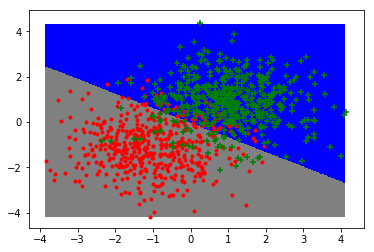

In [299]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
perceptron8 = Perceptron(hinge,hinge_g,max_iter=200,eps=0.2, kernel=None,typeUp='stochastique')
perceptron8.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron8.score(trainx,trainy),perceptron8.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron8.predict,200)
plot_data(trainx,trainy)

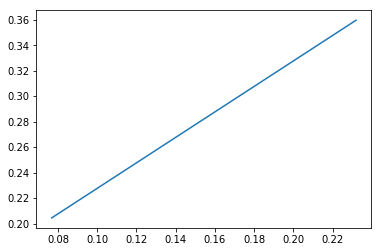

In [300]:
hist=perceptron8.w_hist
h=np.zeros((len(hist),2))
for i in range(len( hist)):
    e=hist[i]
    h[i][0]=e[0][0]
    h[i][1]=e[0][1]
    
plt.plot(h[:,0],h[:,1], label="trajectoire de l'optimisation")
plt.show()

Hinge-Erreur : train 0.920000, test 0.902000


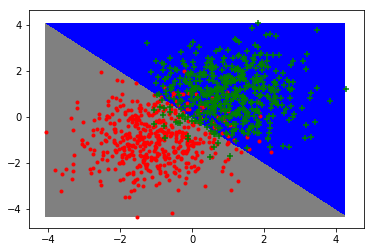

In [304]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
perceptron8 = Perceptron(mse,mse_g,max_iter=200,eps=0.2, kernel=None,typeUp='stochastique')
perceptron8.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron8.score(trainx,trainy),perceptron8.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron8.predict,200)
plot_data(trainx,trainy)

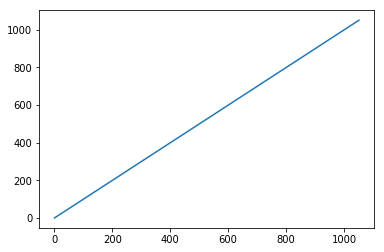

In [305]:
hist=perceptron8.w_hist
h=np.zeros((len(hist),2))
for i in range(len( hist)):
    e=hist[i]
    h[i][0]=e[0][0]
    h[i][1]=e[0][1]
    
plt.plot(h[:,0],h[:,1], label="trajectoire de l'optimisation")
plt.show()

In [301]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)

nb=np.arange(100,1000,100)
resultsTrain=[]
resultsTest=[]

for i in range(len(nb)):
    perceptron9 = Perceptron(hinge,hinge_g,max_iter=nb[i],eps=0.2, kernel=None, sigma=0.2,typeUp='batch')
    k=perceptron9.fit(trainx,trainy)
    t=perceptron9.score(trainx,trainy)
    resultsTrain.append(perceptron9.score(trainx,trainy))
    resultsTest.append(perceptron9.score(testx,testy))
    


<center> <h1> Considération du biais </h1></center>

Hinge-Erreur : train 0.869000, test 0.879000


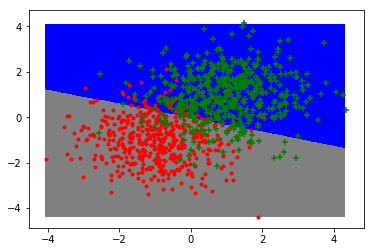

In [306]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
perceptron8 = Perceptron(hinge,hinge_g,max_iter=200,eps=0.2, kernel=None,typeUp='minibatch')
perceptron8.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron8.score(trainx,trainy),perceptron8.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron8.predict,200)
plot_data(trainx,trainy)

Hinge-Erreur : train 0.906000, test 0.906000


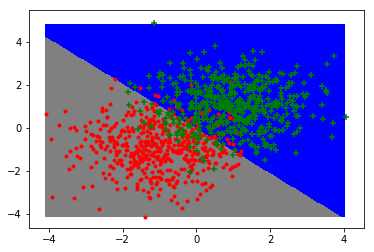

In [309]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
perceptron8 = Perceptron(mse,mse_g,max_iter=200,eps=0.2, kernel="bias",typeUp='stochastique')
perceptron8.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron8.score(trainx,trainy),perceptron8.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron8.predict,200)
plot_data(trainx,trainy)

<center> <h1> Btach - Stochastique - MiniBatch </h1></center>

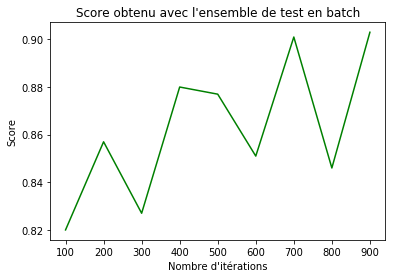

In [302]:
plt.plot(nb, resultsTest, 'g',label="Ensemble de test")
plt.title("Score obtenu avec l'ensemble de test en batch")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Score")
plt.show()

In [118]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)

nb=np.arange(100,1000,100)
resultsTrain=[]
resultsTest=[]

for i in range(len(nb)):
    perceptron9 = Perceptron(hinge,hinge_g,max_iter=nb[i],eps=0.1, kernel=None, sigma=0.2,typeUp='stochastique')
    k=perceptron9.fit(trainx,trainy)
    t=perceptron9.score(trainx,trainy)
    resultsTrain.append(perceptron9.score(trainx,trainy))
    resultsTest.append(perceptron9.score(testx,testy))
    

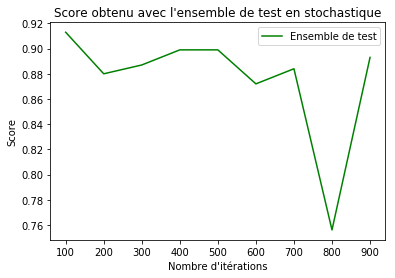

In [120]:
plt.plot(nb, resultsTest, 'g',label="Ensemble de test")
plt.title("Score obtenu avec l'ensemble de test en stochastique")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Score")
plt.legend()
plt.show()

In [122]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)

nb=np.arange(100,1000,100)
resultsTrain=[]
resultsTest=[]

for i in range(len(nb)):
    perceptron9 = Perceptron(hinge,hinge_g,max_iter=nb[i],eps=0.1, kernel=None, sigma=0.2,typeUp='minibatch')
    k=perceptron9.fit(trainx,trainy)
    t=perceptron9.score(trainx,trainy)
    resultsTrain.append(perceptron9.score(trainx,trainy))
    resultsTest.append(perceptron9.score(testx,testy))
    

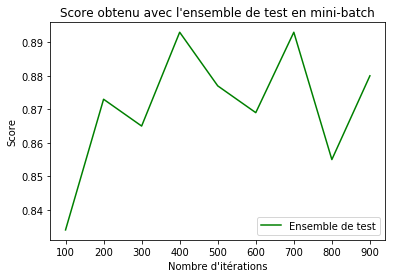

In [123]:
plt.plot(nb, resultsTest, 'g',label="Ensemble de test")
plt.title("Score obtenu avec l'ensemble de test en mini-batch")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Score")
plt.legend()
plt.show()

<center> <h1> Données USPS</h1></center>

In [344]:
datax_train, datay_train = load_usps("USPS_train.txt")
datax_test, datay_test = load_usps("USPS_test.txt")

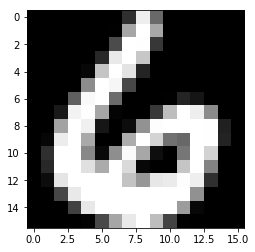

In [345]:
show_usps(datax_train[0])


### Éxpérience d'apprentissage sans biais

### 6 VS 9

In [372]:
datax_train69, datay_train69 = filter_data(datax_train, datay_train, 6, 9)
datax_test69, datay_test69= filter_data(datax_test, datay_test, 6, 9)

Hinge-Erreur : train 0.507645, test 0.489914


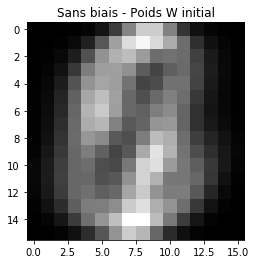

In [373]:
perceptron3 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.01, kernel=None,typeUp='batch',w_type='mean')
perceptron3.fit(datax_train69,datay_train69)
print("Hinge-Erreur : train %f, test %f"% (perceptron3.score(datax_train69,datay_train69),perceptron3.score(datax_test69,datay_test69)))
plt.title("Sans biais - Poids W initial")
plt.imshow(perceptron3.w_init.reshape(16,16), cmap="gray")
plt.show()

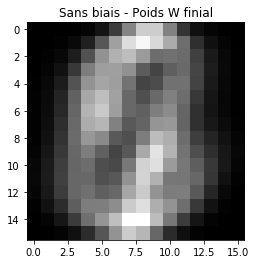

In [374]:
plt.title("Sans biais - Poids W finial")
plt.imshow(perceptron3.w.reshape(16,16), cmap="gray")
plt.show()

### 1 VS 7

In [364]:
datax_train17, datay_train17 = dataset1v1(datax_train, datay_train, 1,7)
datax_test17, datay_test17= dataset1v1(datax_test, datay_test, 1,7)

Hinge-Erreur : train 0.610909, test 0.642336


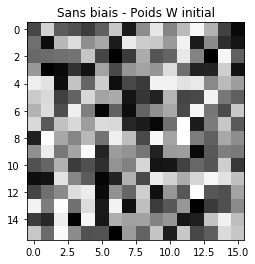

In [365]:
perceptron4 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.01, kernel=None,typeUp='batch')
perceptron4.fit(datax_train17,datay_train17)
print("Hinge-Erreur : train %f, test %f"% (perceptron4.score(datax_train17,datay_train17),perceptron4.score(datax_test17,datay_test17)))
plt.title("Sans biais - Poids W initial")
plt.imshow(perceptron4.w_init.reshape(16,16), cmap="gray")
plt.show()

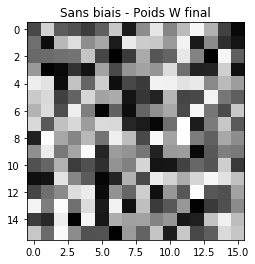

In [366]:
plt.title("Sans biais - Poids W final")
plt.imshow(perceptron4.w.reshape(16,16), cmap="gray")
plt.show()

### 6 VS All

In [358]:
datax_train6, datay_train6 = filter_oneVSall(datax_train, datay_train, 6)
datax_test6, datay_test6=filter_oneVSall(datax_test, datay_test, 6)

Hinge-Erreur : train 0.908929, test 0.915296


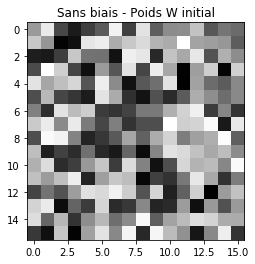

In [359]:
perceptron4 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.01, kernel=None,typeUp='batch')
perceptron4.fit(datax_train6,datay_train6)
print("Hinge-Erreur : train %f, test %f"% (perceptron4.score(datax_train6,datay_train6),perceptron4.score(datax_test6,datay_test6)))
plt.title("Sans biais - Poids W initial")
plt.imshow(perceptron4.w_init.reshape(16,16), cmap="gray")
plt.show()

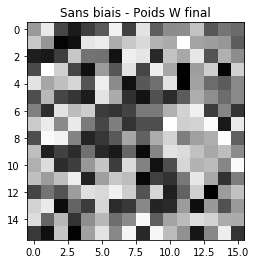

In [360]:
plt.title("Sans biais - Poids W final")
plt.imshow(perceptron4.w.reshape(16,16), cmap="gray")
plt.show()

Hinge-Erreur : train 1.000000, test 0.044638


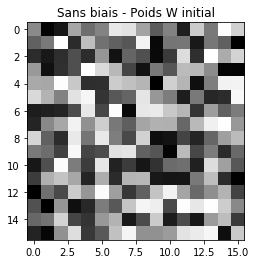

In [132]:
perceptron5= Perceptron(hinge,hinge_g,max_iter=1000,eps=0.1, kernel=None)
perceptron5.fit(datax_train6,datay_train6)
print("Hinge-Erreur : train %f, test %f"% (perceptron5.score(datax_train6,datay_train6),perceptron5.score(datax_test_no6,datay_test_no6)))
plt.title("Sans biais - Poids W initial")
plt.imshow(perceptron5.w_init.reshape(16,16), cmap="gray")
plt.show()

In [375]:
steps=np.arange(50,1000,100)
train,test=[],[]
for i in steps:
    perceptron6= Perceptron(hinge,hinge_g,max_iter=i,eps=0.1, kernel=None,typeUp='batch')
    perceptron6.fit(datax_train69,datay_train69)
    train.append(perceptron6.score(datax_train69,datay_train69))
    test.append(perceptron6.score(datax_test69,datay_test69))


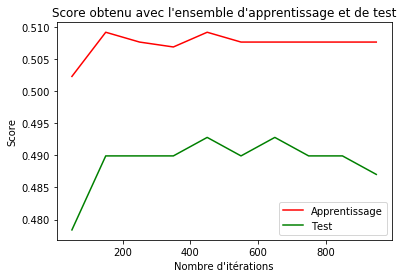

In [376]:
plt.plot(steps, train, 'r', label = "Apprentissage")
plt.plot(steps, test, 'g', label = "Test")
plt.title("Score obtenu avec l'ensemble d'apprentissage et de test")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Score")
plt.legend()
plt.show()

<center> <h1>  Données 2D et projection </h1></center>

## Expériences sur les données artificielles

Hinge-Erreur : train 0.494000, test 0.505000


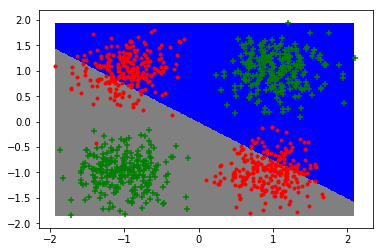

In [163]:
trainx,trainy = gaussienne(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.1)
testx,testy =  gaussienne(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.1)
perceptron9 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel=None)
perceptron9.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron9.score(trainx,trainy),perceptron9.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron9.predict,200)
plot_data(trainx,trainy)


## Projection polynomial

kernel  detected: bias3D
Hinge-Erreur : train 0.945000, test 0.953000


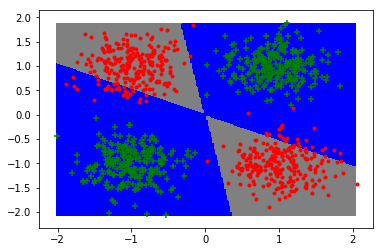

In [126]:
trainx,trainy = gaussienne(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.1)
testx,testy =  gaussienne(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.1)
perceptron9 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel="poly3D")
perceptron9.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron9.score(trainx,trainy),perceptron9.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron9.predict,200)
plot_data(trainx,trainy)


bias detected
(1, 5)
(1000, 5)
Hinge-Erreur : train 0.903000, test 0.901000


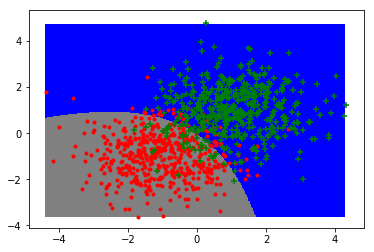

In [36]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
perceptron8 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel="poly")
perceptron8.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron8.score(trainx,trainy),perceptron8.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron8.predict,200)
plot_data(trainx,trainy)


kernel  detected
Hinge-Erreur : train 0.997000, test 0.994000


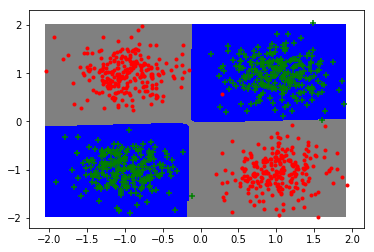

In [20]:
trainx,trainy = gaussienne(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.1)
testx,testy =  gaussienne(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=1,epsilon=0.1)
perceptron9 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel="poly")
perceptron9.fit(trainx,trainy)
print("Hinge-Erreur : train %f, test %f"% (perceptron9.score(trainx,trainy),perceptron9.score(testx,testy)))
plt.figure()
plot_frontiere(trainx,perceptron9.predict,200)
plot_data(trainx,trainy)


## Noyau Gaussien 

### Expériences en fonction de sigma et  de la variante de l'agorithme (batch - mini-batch - stochastique)

kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss


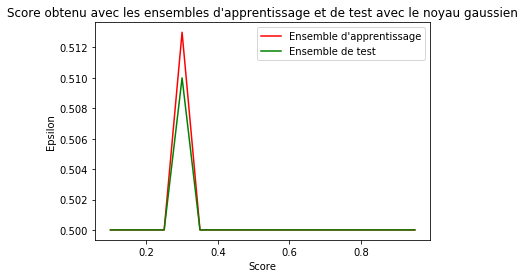

In [26]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)

sigmas=np.arange(0.1,1,0.05)
resultsTrain=[]
resultsTest=[]

for i in range(len(sigmas)):
    perceptron9 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel="gauss",sigma=sigmas[i],typeUp='minibatch')
    perceptron9.fit(trainx,trainy)
    perceptron9.score(trainx,trainy)
    resultsTrain.append(perceptron9.score(trainx,trainy))
    resultsTest.append(perceptron9.score(testx,testy))
    
plt.plot(sigmas, resultsTrain, 'r', label="Ensemble d'apprentissage")
plt.plot(sigmas, resultsTest, 'g',label="Ensemble de test")
plt.title("Score obtenu avec les ensembles d'apprentissage et de test avec le noyau gaussien")
plt.xlabel("Score")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss
kernel  detected: gauss


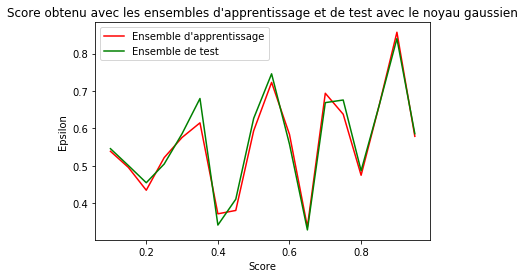

In [27]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)

sigmas=np.arange(0.1,1,0.05)
resultsTrain=[]
resultsTest=[]

for i in range(len(sigmas)):
    perceptron9 = Perceptron(hinge,hinge_g,max_iter=1000,eps=0.2, kernel="gauss",sigma=sigmas[i],typeUp='stochastique')
    perceptron9.fit(trainx,trainy)
    perceptron9.score(trainx,trainy)
    resultsTrain.append(perceptron9.score(trainx,trainy))
    resultsTest.append(perceptron9.score(testx,testy))
    
plt.plot(sigmas, resultsTrain, 'r', label="Ensemble d'apprentissage")
plt.plot(sigmas, resultsTest, 'g',label="Ensemble de test")
plt.title("Score obtenu avec les ensembles d'apprentissage et de test avec le noyau gaussien")
plt.xlabel("Score")
plt.ylabel("Epsilon")
plt.legend()
plt.show()